In [1]:
import os
# Find the latest version of spark 3.x  from http://www.apache.org/dist/spark/ and enter as the spark version
# For example:
# spark_version = 'spark-3.4.0'
spark_version = 'spark-3.4.4'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://www.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop3.tgz
!tar xf $SPARK_VERSION-bin-hadoop3.tgz
!pip install -q findspark

# Set Environment Variables
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop3"

# Start a SparkSession
import findspark
findspark.init()

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,173 kB]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:12 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [8,514 kB]
Get:13 https://r2u.stat.illinois.edu/ubuntu jammy/

In [2]:
# Import packages
from pyspark.sql import SparkSession
import time

# Create a SparkSession
spark = SparkSession.builder.appName("SparkSQL").getOrCreate()

In [3]:
# Read in data from S3 Bucket
from pyspark import SparkFiles
url = "https://project4-nyctaxi.s3.us-east-1.amazonaws.com/new_train.csv"
spark.sparkContext.addFile(url)
df = spark.read.csv(SparkFiles.get("new_train.csv"), sep=",", header=True)
df.show()

+-------------------+-------------------+---------------+---------------+----------------+------------------+-------------+------------------+------------------+------------------+-----------------+
|    pickup_datetime|   dropoff_datetime|passenger_count|pickup_location|dropoff_location|store_and_fwd_flag|trip_duration|   pickup_latitude|  pickup_longitude|  dropoff_latitude|dropoff_longitude|
+-------------------+-------------------+---------------+---------------+----------------+------------------+-------------+------------------+------------------+------------------+-----------------+
|2024-01-03 22:50:16|2024-01-03 22:59:25|            1.0|             50|             236|                 N|          549|218437.82028573466| 985597.5343919232| 223613.7535760244|996155.3867656847|
|2024-01-25 09:33:05|2024-01-25 09:48:58|            1.0|            238|             230|                 N|          953|227717.51805898765| 991712.7644413216| 216099.1397683868|988628.0600467023|
|2024

In [4]:
df.show()

+-------------------+-------------------+---------------+---------------+----------------+------------------+-------------+------------------+------------------+------------------+-----------------+
|    pickup_datetime|   dropoff_datetime|passenger_count|pickup_location|dropoff_location|store_and_fwd_flag|trip_duration|   pickup_latitude|  pickup_longitude|  dropoff_latitude|dropoff_longitude|
+-------------------+-------------------+---------------+---------------+----------------+------------------+-------------+------------------+------------------+------------------+-----------------+
|2024-01-03 22:50:16|2024-01-03 22:59:25|            1.0|             50|             236|                 N|          549|218437.82028573466| 985597.5343919232| 223613.7535760244|996155.3867656847|
|2024-01-25 09:33:05|2024-01-25 09:48:58|            1.0|            238|             230|                 N|          953|227717.51805898765| 991712.7644413216| 216099.1397683868|988628.0600467023|
|2024

In [6]:
import pandas as pd

p_df = pd.read_csv("https://project4-nyctaxi.s3.us-east-1.amazonaws.com/new_train.csv")
p_df.head()

,pickup_datetime,dropoff_datetime,passenger_count,pickup_location,dropoff_location,store_and_fwd_flag,trip_duration,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude
0,2024-01-03 22:50:16,2024-01-03 22:59:25,1.0,50,236,N,549,218437.820286,985597.534392,223613.753576,996155.386766
1,2024-01-25 09:33:05,2024-01-25 09:48:58,1.0,238,230,N,953,227717.518059,991712.764441,216099.139768,988628.060047
2,2024-01-11 19:14:23,2024-01-11 19:55:29,1.0,237,1,N,2466,219305.827826,993769.023714,191376.749531,935996.821016
3,2024-01-04 21:30:56,2024-01-04 21:38:43,1.0,230,68,N,467,216099.139768,988628.060047,211948.912400,984272.778633
4,2024-01-11 11:13:18,2024-01-11 11:19:52,1.0,88,13,N,394,195528.924799,981057.264296,198691.525438,979792.331029


In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
# Load the dataset (CSV file should be downloaded first)
# Update this path to where the file is located
file_path = "https://project4-nyctaxi.s3.us-east-1.amazonaws.com/new_train.csv"
data = pd.read_csv(file_path)
# Basic data inspection
print(data.info())
print(data.head())
# Drop rows with missing target variable (trip duration)
data.dropna(subset=['trip_duration'], inplace=True)
# Feature engineering
# Convert pickup datetime to datetime object
data['pickup_datetime'] = pd.to_datetime(data['pickup_datetime'])
data['hour_of_day'] = data['pickup_datetime'].dt.hour
data['day_of_week'] = data['pickup_datetime'].dt.dayofweek
# Add distance feature (Haversine formula for distance between pickup and dropoff)
def haversine(lon1, lat1, lon2, lat2):
    # Convert degrees to radians
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    # Earth radius in km (mean radius)
    return 6371 * c
data['distance'] = haversine(data['pickup_longitude'], data['pickup_latitude'],
                             data['dropoff_longitude'], data['dropoff_latitude'])
# Selecting relevant features for the model
features = ['hour_of_day', 'day_of_week', 'passenger_count', 'distance']
X = data[features]
y = data['trip_duration']  # Target variable: trip duration
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Initialize and train the model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
# Predict on test data
y_pred = model.predict(X_test)
# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error: {mae}')
# Feature importance visualization
feature_importances = model.feature_importances_
plt.barh(features, feature_importances)
plt.xlabel('Feature Importance')
plt.title('Random Forest Feature Importance')
plt.show()
# Prediction vs Actuals
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([0, max(y_test)], [0, max(y_pred)], color='red', linewidth=2)
plt.xlabel('Actual Trip Duration')
plt.ylabel('Predicted Trip Duration')
plt.title('Actual vs Predicted Trip Duration')
plt.show()


SyntaxError: invalid syntax (<ipython-input-11-2fd3d58901c4>, line 74)

In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

In [20]:
# Load the dataset (CSV file should be downloaded first)
# Update this path to where the file is located
file_path = "https://project4-nyctaxi.s3.us-east-1.amazonaws.com/new_test.csv"
data = pd.read_csv(file_path)
# Basic data inspection
print(data.info())
print(data.head())
# Drop rows with missing target variable (trip duration)
data.dropna(subset=['trip_duration'], inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 558962 entries, 0 to 558961
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   pickup_datetime     558962 non-null  object 
 1   dropoff_datetime    558962 non-null  object 
 2   passenger_count     558962 non-null  float64
 3   pickup_location     558962 non-null  int64  
 4   dropoff_location    558962 non-null  int64  
 5   store_and_fwd_flag  558962 non-null  object 
 6   trip_duration       558962 non-null  int64  
 7   pickup_latitude     558962 non-null  float64
 8   pickup_longitude    558962 non-null  float64
 9   dropoff_latitude    558962 non-null  float64
 10  dropoff_longitude   558962 non-null  float64
dtypes: float64(5), int64(3), object(3)
memory usage: 46.9+ MB
None
       pickup_datetime     dropoff_datetime  passenger_count  pickup_location  \
0  2024-01-28 15:45:48  2024-01-28 16:03:54              2.0              162   
1  2024-0

In [21]:
# Feature engineering
# Convert pickup datetime to datetime object
data['pickup_datetime'] = pd.to_datetime(data['pickup_datetime'])
data['hour_of_day'] = data['pickup_datetime'].dt.hour
data['day_of_week'] = data['pickup_datetime'].dt.dayofweek

In [22]:
data['day_of_week'].unique()

array([6, 2, 1, 4, 0, 3, 5], dtype=int32)

In [23]:
# Add distance feature (Haversine formula for distance between pickup and dropoff)
def haversine(lon1, lat1, lon2, lat2):
    # Convert degrees to radians
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    # Earth radius in km (mean radius)
    return 6371 * c
data['distance'] = haversine(data['pickup_longitude'], data['pickup_latitude'],
                             data['dropoff_longitude'], data['dropoff_latitude'])

In [24]:
# Selecting relevant features for the model
features = ['hour_of_day', 'day_of_week', 'passenger_count', 'distance']
X = data[features]
y = data['trip_duration']  # Target variable: trip duration
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [25]:
# Initialize and train the model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [26]:
# Predict on test data
y_pred = model.predict(X_test)

In [27]:
# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error: {mae}')

Mean Absolute Error: 342.3740715613492


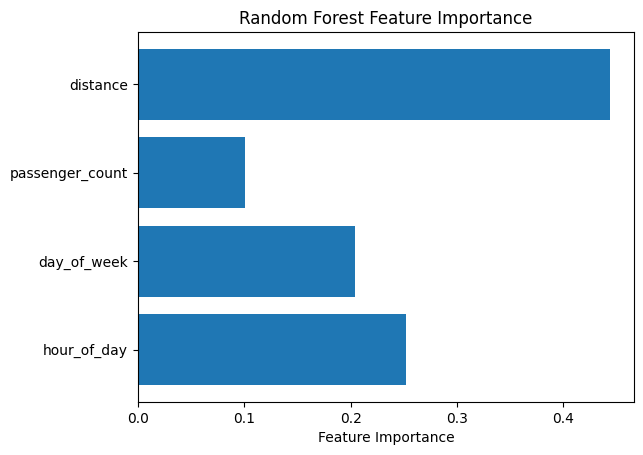

In [28]:
# Feature importance visualization
feature_importances = model.feature_importances_
plt.barh(features, feature_importances)
plt.xlabel('Feature Importance')
plt.title('Random Forest Feature Importance')
plt.show()

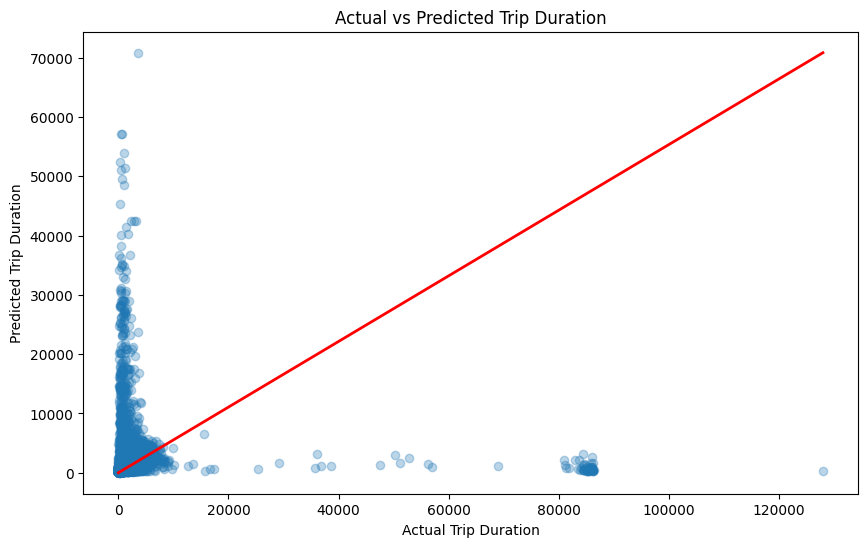

In [29]:
# Prediction vs Actuals
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([0, max(y_test)], [0, max(y_pred)], color='red', linewidth=2)
plt.xlabel('Actual Trip Duration')
plt.ylabel('Predicted Trip Duration')
plt.title('Actual vs Predicted Trip Duration')
plt.show()